<a href="https://colab.research.google.com/github/joanby/tensorflow2/blob/master/Collab%2012%20-%20Crear%20una%20API%20para%20Clasificar%20Imágenes%20con%20TensorFlow%20Serving.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Paso 1: Instalar las dependencias y configurar el proyecto en GPU


In [1]:
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  42652      0 --:--:-- --:--:-- --:--:-- 43279
OK
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,012 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:7 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server-universal amd64 Packages [348 B]
Ign:8 https://developer.download.

In [2]:
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 36 not upgraded.
Need to get 326 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.5.0 [326 MB]
Fetched 326 MB in 4s (86.2 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 160690 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.5.0_all.deb ...
Unpacking tensorflow-model-server (2.5.0) ...
Setting up tensorflow-model-server (2.5.0) ...


In [3]:
#!pip install tensorflow-gpu==1.13.1

In [4]:
!pip install requests

## Paso 2: Importar las dependencias del proyecto

In [5]:
import os
import json
import random
import requests
import subprocess
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import cifar10

%matplotlib inline
tf.__version__

'2.4.1'

## Paso 3: Pre procesado de los datos

### Cargar el dataset

In [6]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [7]:
class_names = ['avión', 'coche', 'pájaro', 'gato', 'ciervo', 'perro', 'rana', 'caballo', 'barco', 'camión']

### Normalización de imágenes

In [8]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [9]:
X_train.shape

(50000, 32, 32, 3)

## Paso 4: Definir el modelo

NOTA: Vamos a usar el mismo modelo que creamos en la Sección de Redes Neuronales Convolucionales

In [10]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[32, 32, 3]))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dense(units=10, activation='softmax'))

### Compilar el modelo

In [11]:
model.compile(optimizer='Adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['sparse_categorical_accuracy'])

###  Entrenar el modelo

In [12]:
model.fit(X_train, 
          y_train, 
          batch_size=128, 
          epochs=10)

Epoch 1/10
391/391 [==============================] - 37s 10ms/step - loss: 1.7559 - sparse_categorical_accuracy: 0.3593
Epoch 2/10
391/391 [==============================] - 4s 10ms/step - loss: 1.1368 - sparse_categorical_accuracy: 0.5965
Epoch 3/10
391/391 [==============================] - 4s 10ms/step - loss: 0.9009 - sparse_categorical_accuracy: 0.6839
Epoch 4/10
391/391 [==============================] - 4s 10ms/step - loss: 0.7638 - sparse_categorical_accuracy: 0.7364
Epoch 5/10
391/391 [==============================] - 4s 10ms/step - loss: 0.6647 - sparse_categorical_accuracy: 0.7682
Epoch 6/10
391/391 [==============================] - 4s 10ms/step - loss: 0.5696 - sparse_categorical_accuracy: 0.8034
Epoch 7/10
391/391 [==============================] - 4s 10ms/step - loss: 0.4957 - sparse_categorical_accuracy: 0.8284
Epoch 8/10
391/391 [==============================] - 4s 10ms/step - loss: 0.4189 - sparse_categorical_accuracy: 0.8532
Epoch 9/10
391/391 [===================

### Evaluar el modelo

In [13]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.9447 - sparse_categorical_accuracy: 0.7295


In [14]:
print("La precisión del modelo es de {} %".format(test_accuracy*100.0))

La precisión del modelo es de 72.94999957084656 %


## Paso 5: Guardar el modelo para subir a producción

### Crear un directorio para el modelo

In [24]:
MODEL_DIR = "model/"
version = 1

In [25]:
export_path = os.path.join(MODEL_DIR, str(version))
export_path

'model/1'

In [26]:
if os.path.isdir(export_path):
    !rm -r {export_path}

### Guardar el modelo para TensorFlow Serving

In [28]:
#tf.saved_model.simple_save(tf.keras.backend.get_session(), export_dir=export_path, inputs={"input_image":model.input}, outputs={t.name:t for t in model.outputs})
#tf.saved_model.save(model, export_path )
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}

export_path = model/1

INFO:tensorflow:Assets written to: model/1/assets

Saved model:
total 188
drwxr-xr-x 2 root root   4096 Apr 24 23:06 assets
-rw-r--r-- 1 root root 181722 Apr 24 23:09 saved_model.pb
drwxr-xr-x 2 root root   4096 Apr 24 23:09 variables


## Paso 6: Configurar el entorno de producción

### Exportar el MODEL_DIR a las variables de entorno

In [29]:
os.environ['MODEL_DIR'] = os.path.abspath(MODEL_DIR)

### Ejecutar la API REST de TensorFlow Serving

In [32]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8000 \
  --model_name=cifar10 \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 2 in a separate thread.


In [33]:
!tail server.log

2021-04-24 23:10:05.693238: I tensorflow_serving/servables/tensorflow/saved_model_warmup_util.cc:59] No warmup data file found at /content/model/1/assets.extra/tf_serving_warmup_requests
2021-04-24 23:10:05.693350: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: cifar10 version: 1}
2021-04-24 23:10:05.693922: I tensorflow_serving/model_servers/server_core.cc:486] Finished adding/updating models
2021-04-24 23:10:05.693977: I tensorflow_serving/model_servers/server.cc:367] Profiler service is enabled
2021-04-24 23:10:05.694370: I tensorflow_serving/model_servers/server.cc:393] Running gRPC ModelServer at 0.0.0.0:8500 ...
[warn] getaddrinfo: address family for nodename not supported
[evhttp_server.cc : 230] NET_LOG: Couldn't bind to port 8000
[evhttp_server.cc : 63] NET_LOG: Server has not been terminated. Force termination now.
[evhttp_server.cc : 265] NET_LOG: Server is not running ...
2021-04-24 23:10:05.695282: E tensorflow_serving/model_ser

## Paso 7: Crear nuestra primera petición por POST

In [35]:
random_image = np.random.randint(0, len(X_test))
random_image

3748

### Crear el objeto de datos en JSON

In [36]:
data = json.dumps({"signature_name":"serving_default", "instances":[X_test[random_image].tolist()]})

In [38]:
data

'{"signature_name": "serving_default", "instances": [[[[0.38823529411764707, 0.5058823529411764, 0.27450980392156865], [0.3686274509803922, 0.49019607843137253, 0.2549019607843137], [0.3764705882352941, 0.5019607843137255, 0.25882352941176473], [0.396078431372549, 0.5137254901960784, 0.27058823529411763], [0.396078431372549, 0.5098039215686274, 0.2627450980392157], [0.38823529411764707, 0.5137254901960784, 0.2627450980392157], [0.38823529411764707, 0.5058823529411764, 0.25882352941176473], [0.403921568627451, 0.5019607843137255, 0.2549019607843137], [0.40784313725490196, 0.5019607843137255, 0.2549019607843137], [0.4, 0.4980392156862745, 0.24705882352941178], [0.396078431372549, 0.5019607843137255, 0.24705882352941178], [0.38823529411764707, 0.49411764705882355, 0.24313725490196078], [0.3803921568627451, 0.4980392156862745, 0.25098039215686274], [0.38823529411764707, 0.5058823529411764, 0.25882352941176473], [0.396078431372549, 0.5019607843137255, 0.25882352941176473], [0.40784313725490

### Enviar la primera petición POST al modelo

In [39]:
headers = {"content-type":"application/json"}

In [50]:
json_response = requests.post(url="http://localhost:8000/v1/models/cifar10:predict", data=data, headers=headers)

In [51]:
json_response

<Response [200]>

In [52]:
predictions = json.loads(json_response.text)['predictions']

In [53]:
predictions

[[4.97211113e-06,
  2.80566439e-07,
  0.262554318,
  0.00617957488,
  9.06954592e-05,
  0.65721041,
  7.78969635e-08,
  0.0737724677,
  1.0199974e-06,
  0.000186167061]]

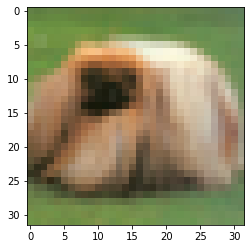

In [54]:
plt.imshow(X_test[random_image])

In [55]:
class_names[np.argmax(predictions[0])]

'perro'

## Paso 8: Enviar una petición POST a un modelo específico 

In [56]:
specific_json_response = requests.post(url="http://localhost:8000/v1/models/cifar10/versions/1:predict", data=data, headers=headers)

In [57]:
specific_json_response

<Response [200]>